### Here is contained all data processing code for my master Thesis

## Setup

In [12]:
import re,os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
# re patterns
pub_pattern = r'cycles: (\d+) instruction: (\d+) start_ns: (\d+) end_ns: (\d+) start_s: (\d+) end_s: (\d+)'
sub_pattern = r'(\d+) received_s: (\d+) received_ns: (\d+)'

base_dir=os.path.join("data/wildcards/safe1000/")
base_save_dir="results/wildcards/"

# Calculate the IQR
def calculate_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

- boxplot
- metrics in S
- check consistency of all data

real r505n006    , Rank 001: seconds 7193676, nanosecond 80357538
dummy r505n007    , Rank 002: seconds 16777072, nanosecond 673656936
pub r505n005    , Rank 000: seconds 7260791, nanosecond 680214187

## Retrive data

In [13]:
# Difference r512c07n01 - r512c06n03 :(6108649, 492739614.0)
# r512c07n01: (7791087, 706014589)
# r512c06n03: (13899737,198754203.0)
# Difference r512c07n01 - r512c06n04 :(6211206, 492739614.0)
# r512c06n04: (14104851,588963442.0)
pub_s = 7791087 
pubns = 706014589
sub_s = 13899737
subns = 198754203
sub_s_dummy = 14104851
subns_dummy = 588963442


def timespec_difference_without_skew(start_s, start_ns, end_s, end_ns):
    s_diff = end_s - start_s
    ns_diff = end_ns - start_ns 
    if ns_diff < 0:
        ns_diff += 1e9
        s_diff -= 1
    return s_diff, ns_diff

# get difference in timespec
def timespec_difference(start_s_un, start_ns_un, end_s_un, end_ns_un):
    start_s,start_ns=timespec_difference_without_skew(pub_s,pubns,start_s_un,start_ns_un)
    end_s,end_ns=timespec_difference_without_skew(sub_s,subns, end_s_un, end_ns_un)

    s_diff = end_s - start_s
    ns_diff = end_ns - start_ns 
    if ns_diff < 0:
        ns_diff += 1e9
        s_diff -= 1
    return s_diff, ns_diff
def timespec_difference_dummy(start_s_un, start_ns_un, end_s_un, end_ns_un):
    start_s,start_ns=timespec_difference_without_skew(pub_s,pubns,start_s_un,start_ns_un)
    end_s,end_ns=timespec_difference_without_skew(sub_s_dummy,subns_dummy, end_s_un, end_ns_un)
    s_diff = end_s - start_s
    ns_diff = end_ns - start_ns 
    if ns_diff < 0:
        ns_diff += 1e9
        s_diff -= 1
    return s_diff, ns_diff

In [14]:
sequence = [1,2,4,6,8,12,16]
protocols = ["udp"] #, "udpM"] #For now considering only udp

sent_data = defaultdict(list)
received_data =defaultdict(list)
sent_data_time= defaultdict(list)
sent_data_time_dummy= []
sent_data_dummy = []
received_data_dummy = []

for seq in sequence:
    for prots in protocols:
        # Pub part
        file_path= os.path.join(base_dir,f'pubs/pub_{prots}_part+_{seq}.data')
        with open(file_path, 'r') as file: 
                for line in file:
                    match = re.search(pub_pattern, line)
                    if match:
                        cycles, instruction, start_ns, end_ns, start_s, end_s = match.groups()
                        sent_data[seq].append((int(cycles), int(instruction), int(start_s), int(start_ns), int(end_s), int(end_ns)))
                        s_diff, ns_diff = timespec_difference_without_skew(int(start_s), int(start_ns) , int(end_s) ,int(end_ns) )
                        sent_data_time[seq].append((s_diff, ns_diff))
        # Sub part
        for numb in range(1,seq+1):
            for j in range( int(48 / seq) ):
                file_path= os.path.join(base_dir,f'group{seq}/sub_{prots}_part{numb}_{j}.data')
                with open(file_path, 'r') as file: 
                    for content in file:
                        match = re.search(sub_pattern, content)
                        if match:
                            line_n,received_s, received_ns = match.groups()
                            start_s,start_ns = ((sent_data[seq][int(line_n)][2], sent_data[seq][int(line_n)][3]))
                            s_diff, ns_diff = timespec_difference(start_s, start_ns , int(received_s), int(received_ns))
                            received_data[seq].append((s_diff, ns_diff))

## Outsider
for prots in protocols:
    file_path= os.path.join(base_dir,f'pubs/pub_{prots}_outsider_0.data')
    with open(file_path, 'r') as file: 
                    for line in file:
                        match = re.search(pub_pattern, line)
                        if match:
                            cycles, instruction, start_ns, end_ns, start_s, end_s = match.groups()
                            sent_data_dummy.append((int(cycles), int(instruction), int(start_s), int(start_ns), int(end_s), int(end_ns)))
                            s_diff, ns_diff = timespec_difference_without_skew(int(start_s), int(start_ns) , int(end_s) ,int(end_ns) )
                            sent_data_time_dummy.append((s_diff, ns_diff))
    for j in range(48):
        file_path= os.path.join(base_dir,f'groupd/sub_{prots}_outsider_{j}.data')
        with open(file_path, 'r') as file: 
            for content in file:
                match = re.search(sub_pattern, content)
                if match:
                    line_n, received_s, received_ns = match.groups()
                    start_s,start_ns = ((sent_data_dummy[int(line_n)][2], sent_data_dummy[int(line_n)][3]))
                    s_diff, ns_diff = timespec_difference_dummy(start_s, start_ns , int(received_s), int(received_ns))
                    #print(s_diff,start_s,int(received_s))
                    received_data_dummy.append((s_diff, ns_diff))



### Cleaning data

In [15]:

column_time = {}
column_time_dummy = []

# Convert data to timespec
for ngroup in received_data:
    list_difference=[]
    nlen= len(received_data[ngroup])
    for cycle_data in received_data[ngroup]:
        list_difference.append(cycle_data[0] * 1e6 + cycle_data[1] /1e3) # time in second
    column_time[ngroup]=list_difference
    print(np.average(column_time[ngroup]))

for cycle_data in received_data_dummy:
    column_time_dummy.append( cycle_data[0] * 1e6 + cycle_data[1] / 1e3 )# time in second

# Remove outliers
lower_bound, upper_bound = calculate_iqr(column_time_dummy)
column_time_dummy_cleaned = [x for x in column_time_dummy if lower_bound <= x <= upper_bound]
column_time_cleaned = {}
print(np.average(column_time_dummy),np.average(column_time_dummy_cleaned))
for ngroup, data in column_time.items():
    lower_bound, upper_bound = calculate_iqr(data)
    column_time_cleaned[ngroup] = [x for x in data if lower_bound <= x <= upper_bound]

182.2814755544248
181.9377790878848
182.08954086599508
183.68935481963337
186.5007062724393
186.8527815254237
183.72445755125307
186.85897103442525 185.6861623330551


## Sending - Receiving time

### Bar Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x600 with 0 Axes>

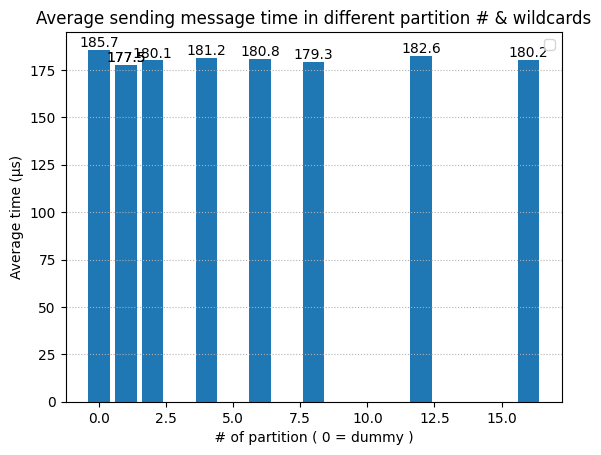

In [16]:
# Prepare data for bar plot
column_averages={}
for ngroup, data in column_time_cleaned.items():
    column_averages[ngroup] = np.average(column_time_cleaned[ngroup])
column_averages[0] = np.average(column_time_dummy_cleaned)

bar_labels = ['dummy']
for i in sequence:
    bar_labels.append(f'{i}group')
bar_colors = ['tab:red', 'tab:orange', 'tab:blue', 'tab:green','tab:purple','tab:pink','tab:cyan','tab:olive']

xvalues=[0]
xvalues.append(1)

yvalues=[column_averages[0]]
yvalues.append(column_averages[1])
for n in sequence:
    xvalues.append(n)
    yvalues.append(column_averages[n])
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
bars= ax.bar(xvalues,yvalues)
# Add values inside each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}', ha='center', va='bottom')
plt.xlabel(" # of partition ( 0 = dummy ) ")
plt.ylabel("Average time (μs)")
plt.legend()
plt.title("Average sending message time in different partition # & wildcards")
plt.grid(axis='y', linestyle=':')
plt.show()

### Box Plot

maxlenght is 47379
Fixing dimension of :  1 47016 47379
Fixing dimension of :  4 47199 47379
Fixing dimension of :  6 47196 47379
Fixing dimension of :  8 47178 47379
Fixing dimension of :  12 47037 47379
Fixing dimension of :  16 47243 47379
dict_keys([1, 2, 4, 6, 8, 12, 16])
data


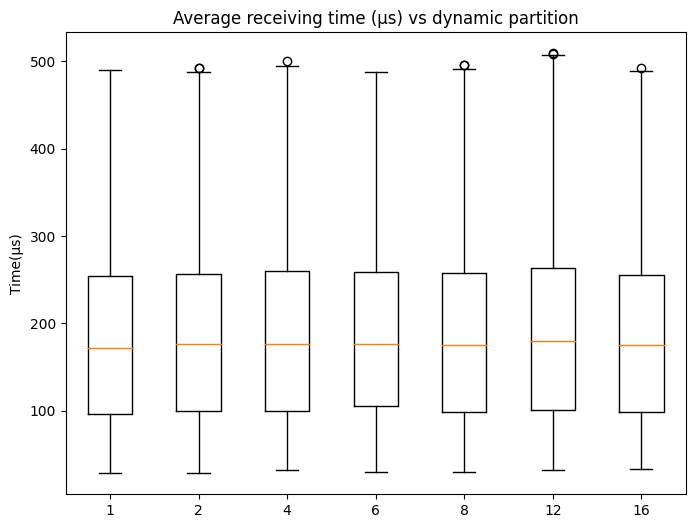

In [17]:
maxlenght = max(len(data) for data in column_time_cleaned.values())
print("maxlenght is {}".format(maxlenght))

# Need to allineate all data
for ngroup, data in column_time_cleaned.items():
    if len(data) < maxlenght:
        print("Fixing dimension of : ",ngroup,len(data),maxlenght)
        column_time_cleaned[ngroup] += [column_averages[ngroup]] * (maxlenght-len(data))
        #print([column_averages[ngroup]]* (maxlenght-len(data)))

plt.figure(figsize=(8, 6))
plt.boxplot(x=column_time_cleaned.values(),data=column_time_cleaned.keys(),labels=sequence)
plt.title("Average receiving time (μs) vs dynamic partition")
plt.ylabel("Time(μs)")

print(column_time_cleaned.keys())

print(base_dir.split('/')[0])
plt.savefig(f"{base_save_dir}boxplot_sendingreceiving_{base_dir.split('/')[2]}.png")

plt.show()



### Uncleaned data

maxlenght is 47494
Fixing dimension of :  1 47166 47494
Fixing dimension of :  4 47252 47494
Fixing dimension of :  6 47348 47494
Fixing dimension of :  8 47350 47494
Fixing dimension of :  12 47200 47494
Fixing dimension of :  16 47363 47494
dict_keys([1, 2, 4, 6, 8, 12, 16])
data


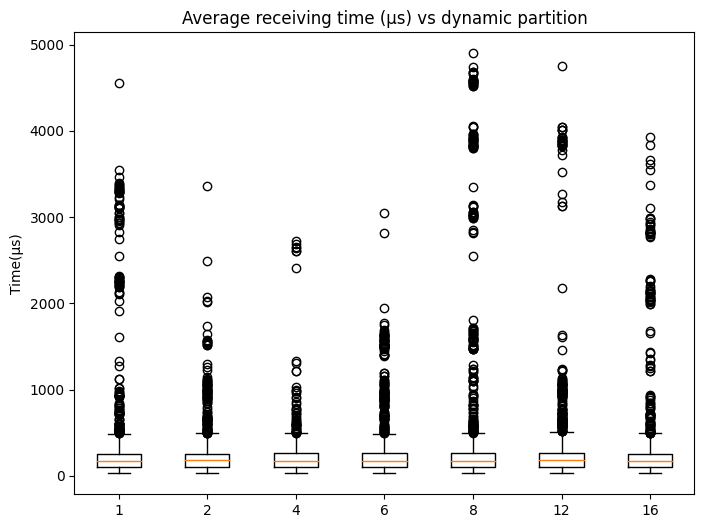

In [18]:
maxlenght = max(len(data) for data in column_time.values())
print("maxlenght is {}".format(maxlenght))

# Need to allineate all data
for prots, data in column_time.items():
    if len(data) < maxlenght:
        print("Fixing dimension of : ",prots,len(data),maxlenght)
        column_time[prots] += [column_averages[prots]] * (maxlenght-len(data))
        #print([column_averages[prots]]* (maxlenght-len(data)))

plt.figure(figsize=(8, 6))
plt.boxplot(x=column_time.values(),data=column_time.keys(),labels=sequence)
plt.title("Average receiving time (μs) vs dynamic partition")
#plt.xlabel("different protocols")
plt.ylabel("Time(μs)")

print(column_time.keys())

print(base_dir.split('/')[0])
plt.show()



## Only sending

### Clean data

In [19]:
column_time_sent = {}
column_time_sent_dummy=[]
# Convert data to timespec
for seq in sent_data_time:
    list_difference=[]
    nlen= len(sent_data_time[seq])
    for cycle_data in sent_data_time[seq]:
        list_difference.append(cycle_data[0] * 1e6 + cycle_data[1] / 1e3) # time in second
    column_time_sent[seq]=list_difference
    print(np.average(column_time_sent[seq]))

for cycle_data in sent_data_time_dummy:
    column_time_sent_dummy.append( cycle_data[0] * 1e6 + cycle_data[1] / 1e3 )# time in second

# Remove outliers
column_time_sent_cleaned = {}

for seq, data in column_time_sent.items():
    lower_bound, upper_bound = calculate_iqr(data)
    column_time_sent_cleaned[seq] = [x for x in data if lower_bound <= x <= upper_bound]

lower_bound, upper_bound = calculate_iqr(column_time_sent_dummy)
column_time_sent_dummy_cleaned = [x for x in column_time_sent_dummy if lower_bound <= x <= upper_bound]

348.960035
341.400679
349.69290799999993
346.22424899999993
350.797304
353.690916
338.471614


<Figure size 1200x600 with 0 Axes>

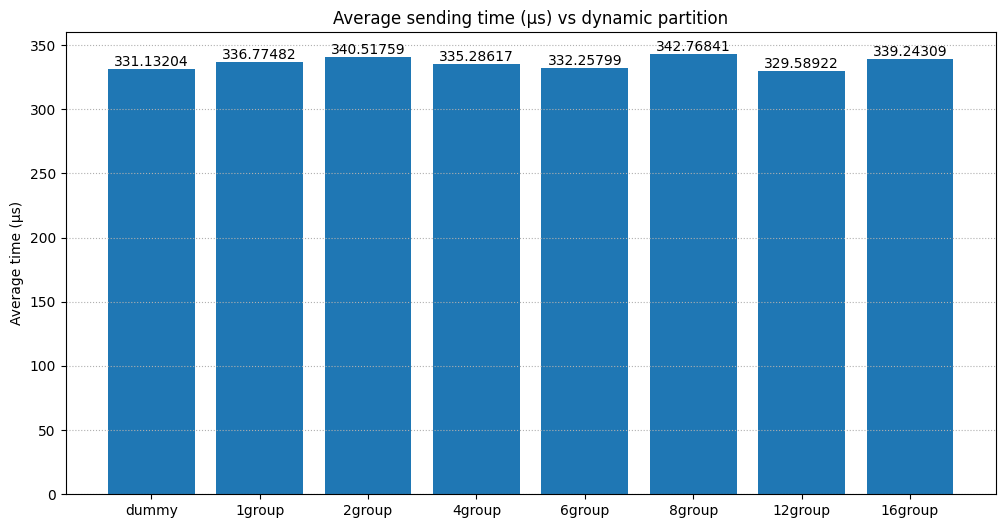

In [20]:
# Prepare data for bar plot
column_averages={}
for ngroup, data in column_time_cleaned.items():
    column_averages[ngroup] = np.average(column_time_sent_cleaned[ngroup])
column_averages[0] = np.average(column_time_sent_dummy_cleaned)

bar_colors = ['tab:red', 'tab:orange', 'tab:blue', 'tab:green','tab:purple','tab:pink','tab:cyan','tab:olive']

plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(figsize=(12,6))
bars= ax.bar(bar_labels,column_averages.values())
# Add values inside each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.5f}', ha='center', va='bottom')
# plt.xlabel(" # of partition ( 0 = dummy ) ")
plt.ylabel("Average time (μs)")
# plt.legend()
plt.title("Average sending time (μs) vs dynamic partition")
plt.grid(axis='y', linestyle=':')
plt.savefig(f"{base_save_dir}barplots_sending_{base_dir.split('/')[2]}.png")

plt.show()

## Instruction vs TSC

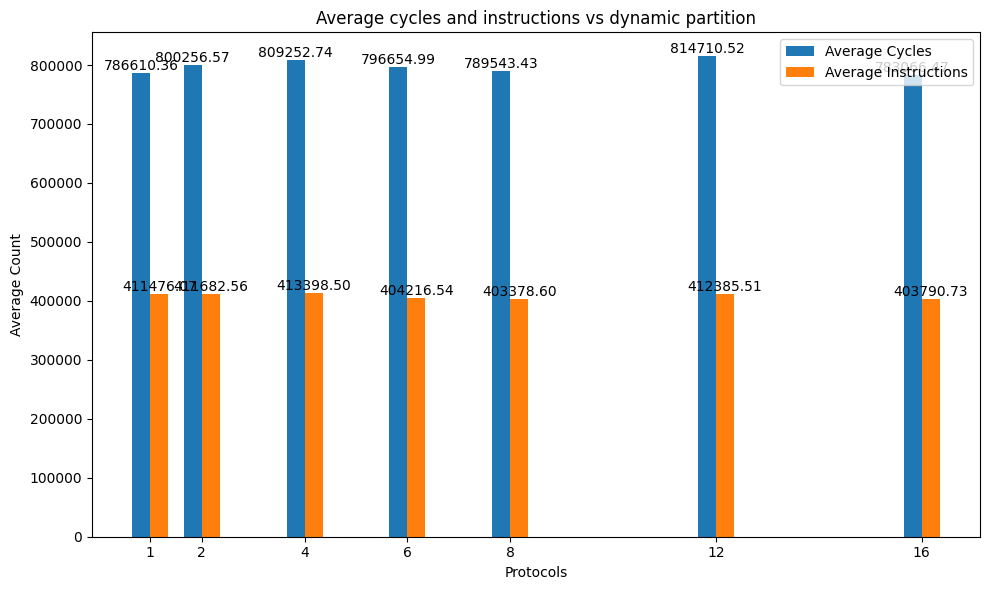

In [21]:
cycles,cycles_cleaned,instructions_cleaned={},{},{}
instructions={}
average_cycles={}
average_instructions={}
for seq in sequence:
    cycles[seq] = [data[0] for data in sent_data[seq]]
    instructions[seq] = [data[1] for data in sent_data[seq]]
    lower_bound, upper_bound = calculate_iqr(cycles[seq])
    cycles_cleaned[seq] = [x for x in cycles[seq] if lower_bound <= x <= upper_bound]
    lower_bound, upper_bound = calculate_iqr(instructions[seq])
    instructions_cleaned[seq] = [x for x in instructions[seq] if lower_bound <= x <= upper_bound]
    average_cycles[seq] = sum(cycles_cleaned[seq]) / len(cycles_cleaned[seq])
    average_instructions[seq] = sum(instructions_cleaned[seq]) / len(instructions_cleaned[seq])

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
x = sequence
barsc = plt.bar(x, average_cycles.values(), width=bar_width, label='Average Cycles')
barsi=plt.bar([i + bar_width for i in x], average_instructions.values(), width=bar_width, label='Average Instructions')
plt.xticks([i + bar_width / 2 for i in x], sequence)
plt.xlabel('Protocols')
plt.ylabel('Average Count')
for bar in barsc:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
for bar in barsi:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
plt.title("Average cycles and instructions vs dynamic partition")
plt.legend()
plt.tight_layout()
plt.show()

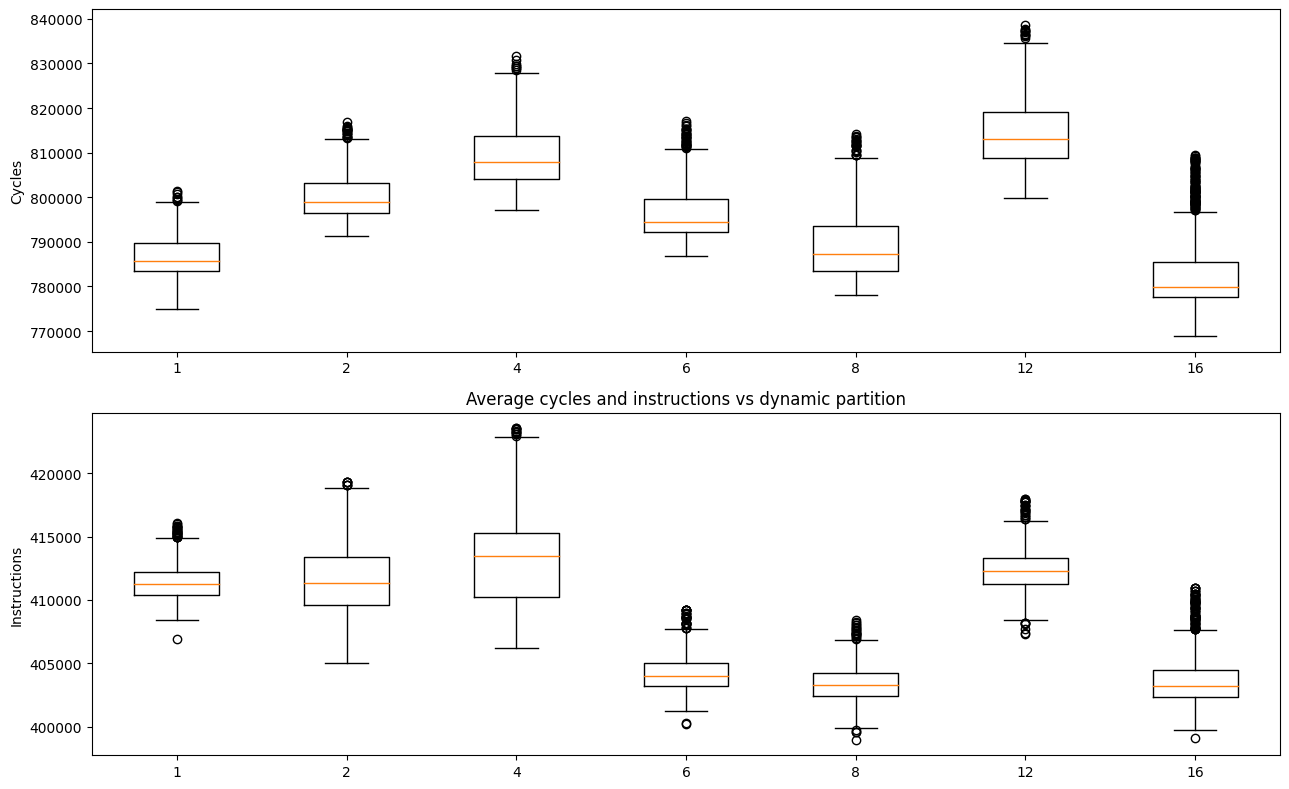

In [22]:
fig, axs = plt.subplots(2, figsize=(13, 8))
plt.title("Average cycles and instructions vs dynamic partition")

# Box plot for cycles
axs[0].boxplot(cycles_cleaned.values())
axs[0].set_xticklabels(cycles_cleaned.keys())
axs[0].set_ylabel('Cycles')

# Box plot for instructions
axs[1].boxplot(instructions_cleaned.values())
axs[1].set_xticklabels(instructions_cleaned.keys())
axs[1].set_ylabel('Instructions')

plt.tight_layout()
plt.savefig(f"{base_save_dir}boxplots_cyclesinstr_{base_dir.split('/')[2]}.png")

plt.show()
